In [7]:
import iris
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/nick/python/ASoP_global/ASoP-Coherence')
from asop_coherence_global import get_asop_dict
import matplotlib.cm as mpl_cm
import numpy as np
import numpy.ma as ma
import pandas as pd

In [8]:
def load_summary_metric(filename,constraint,new_long_name,new_units):
    cube = iris.load_cube(filename,constraint)
    cube.long_name = new_long_name
    cube.units = new_units
    return(cube)

In [9]:
def load_all_summary_metrics(asop_dict,wet_season_threshold='1d24'):
    constraints_longnames_units = [
        ('spatial intermittency on-off metric based on 4 divisions (mean of all months in wet season)','spatial coherence metric, 4 divs, all wet season, 3hr - '+asop_dict['name'],'1'),
        ('Probability of upper division nearby upper division (mean of all months in wet season)','p(on|on), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of upper division nearby lower division (mean of all months in wet season)','p(on|off), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of lower division nearby upper division (mean of all months in wet season)','p(off|on), 4 divs, all wet season, 3hr '+asop_dict['name'],'1'),
        ('Probability of lower division followed by lower division (mean of all months in wet season)','p(off|off), 4 divs, all wet season, 3hr '+asop_dict['name'],'1')
    ]
    out_cubelist = []
    summary_file = asop_dict['desc']+'_asop_spatial_summary_wetseason'+wet_season_threshold+'.nc'
    for constraint,long_name,units in constraints_longnames_units:
        print(constraint)
        cube = load_summary_metric(str(asop_dict['dir']/summary_file),constraint,long_name,units)
        out_cubelist.append(cube)
    return(out_cubelist)

In [10]:
def plot_summary_metric(model_cube,obs_cube,model_dict,obs_dict,raw_levs,diff_levs,raw_cmap,diff_cmap):
    fig = plt.figure()
    raw_cmap = mpl_cm.get_cmap(raw_cmap)
    diff_cmap = mpl_cm.get_cmap(diff_cmap)
    qplt.contourf(model_cube,raw_levs,cmap=raw_cmap)
    plt.gca().coastlines()
    plt.savefig('plots/asop_coherence_global_spatial_'+model_dict['name']+'_'+model_cube.var_name+'.png',dpi=200)

    fig = plt.figure()
    qplt.contourf(obs_cube,raw_levs,cmap=raw_cmap)
    plt.gca().coastlines()
    plt.savefig('plots/asop_coherence_global_spatial_'+obs_dict['name']+'_'+obs_cube.var_name+'.png',dpi=200)

    fig = plt.figure()
    diff_cube = model_cube-obs_cube
    diff_cube.long_name=model_cube.long_name+' diff '+obs_dict['name']
    qplt.contourf(diff_cube,diff_levs,cmap=diff_cmap)
    plt.gca().coastlines()
    plt.savefig('plots/asop_coherence_global_spatial_'+model_dict['name']+'-minus-'+obs_dict['name']+'_'+model_cube.var_name+'.png',dpi=200)

In [28]:
def find_distcorr_threshold(cube,threshold=0.5,long_name=None,units=None):
    import numpy as np
    #max_autocorr = cube.collapsed('lag',iris.analysis.MEAN).copy()
    lon = cube.coord('longitude')
    lat = cube.coord('latitude')
    dist = cube.coord('distance')
    nlon = len(lon.points)
    nlat = len(lat.points)
#    max_autocorr = iris.cube.Cube(np.ma.empty((nlat,nlon)),dim_coords_and_dims=[(lat,0),(lon,1)])
    max_autocorr = np.zeros((nlat,nlon))
    for y in range(nlat):
        for x in range(nlon):
            below_threshold = np.where(cube.data[:,y,x] <= threshold)
            if np.sum(below_threshold) >= 1:
                max_autocorr[y,x] = dist.points[np.amin(below_threshold)]-1
            else:
                max_autocorr[y,x] = np.amax(dist.points)
    max_autocorr_cube = iris.cube.Cube(data=max_autocorr,dim_coords_and_dims=[(lat,0),(lon,1)],long_name=long_name,units=units,var_name='distcorr_threshold'+str(threshold))
    return(max_autocorr_cube) 

In [31]:
models = ['ACCESS_3hr_3x3','FGOALS_3hr_3x3','GISS_3hr_3x3','MIROC_3hr_3x3','MPI-ESM1_3hr_3x3','SAM0-UNICON_3hr_3x3']
gpm_dict = get_asop_dict('GPM_IMERG_3hr_3x3')
ponon_raw_levs=np.arange(0.40,0.80,0.04) #.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
ponon_diff_levs=np.arange(-0.2,0.21,0.04)
gpm_spatial_summary,gpm_ponon,gpm_ponoff,gpm_poffon,gpm_poffoff = load_all_summary_metrics(gpm_dict)
gpm_autocorr_filename = str(gpm_dict['dir'])+'/'+gpm_dict['desc']+'_asop_spatial_corr_wetseason1d24.nc'
gpm_autocorr = load_summary_metric(gpm_autocorr_filename,'distance_correlations',None,'km')
gpm_threshold = find_distcorr_threshold(gpm_autocorr,threshold=threshold,long_name='Distance corr metric, >'+str(threshold)+', all wet season '+gpm_dict['name'],units='km')
ponoff_raw_levs=np.arange(0.0,0.21,0.02) #.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
ponoff_diff_levs=np.arange(-0.10,0.11,0.02)
poffon_raw_levs=np.arange(0.0,0.41,0.04) #.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
poffon_diff_levs=np.arange(-0.20,0.21,0.04)
poffoff_raw_levs=np.arange(0.30,0.9,0.06) #.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9]
poffoff_diff_levs=np.arange(-0.2,0.21,0.04)
summary_raw_levs=np.arange(0.0,0.81,0.05)
summary_diff_levs=np.arange(-0.3,0.31,0.05)
threshold=0.2
autocorr_raw_levels=[0,400,600,800,1000]
autocorr_diff_levels=np.arange(-1000,1001,200)

spatial intermittency on-off metric based on 4 divisions (mean of all months in wet season)
Probability of upper division nearby upper division (mean of all months in wet season)
Probability of upper division nearby lower division (mean of all months in wet season)
Probability of lower division nearby upper division (mean of all months in wet season)
Probability of lower division followed by lower division (mean of all months in wet season)


spatial intermittency on-off metric based on 4 divisions (mean of all months in wet season)
Probability of upper division nearby upper division (mean of all months in wet season)
Probability of upper division nearby lower division (mean of all months in wet season)
Probability of lower division nearby upper division (mean of all months in wet season)
Probability of lower division followed by lower division (mean of all months in wet season)
spatial intermittency on-off metric based on 4 divisions (mean of all months in wet season)
Probability of upper division nearby upper division (mean of all months in wet season)
Probability of upper division nearby lower division (mean of all months in wet season)
Probability of lower division nearby upper division (mean of all months in wet season)
Probability of lower division followed by lower division (mean of all months in wet season)
spatial intermittency on-off metric based on 4 divisions (mean of all months in wet season)
Probability of upp

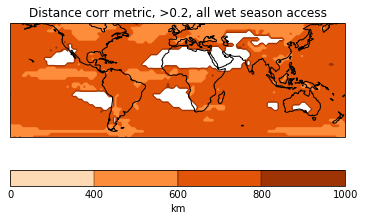

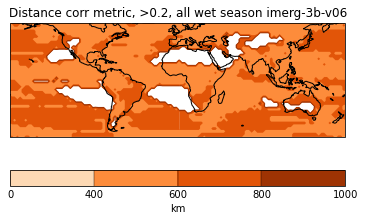

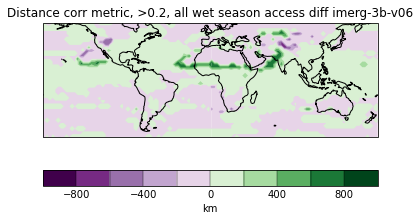

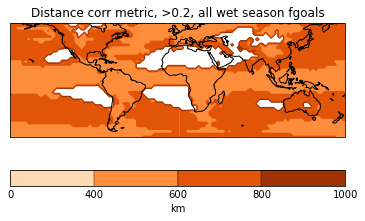

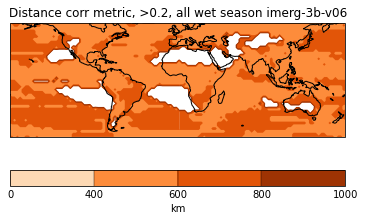

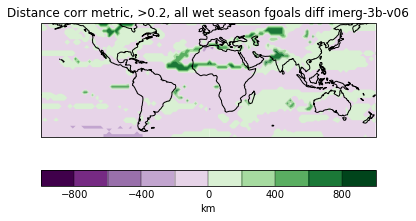

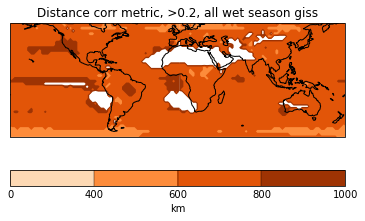

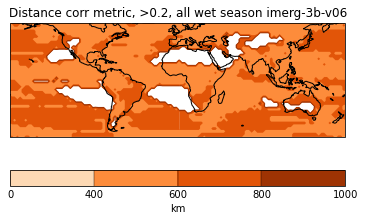

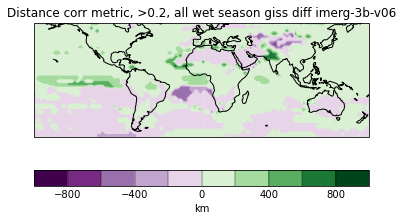

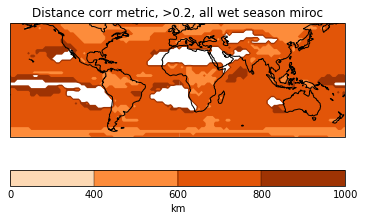

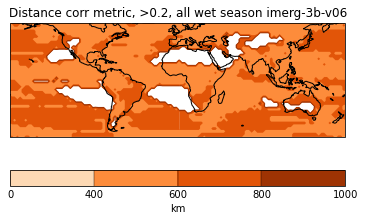

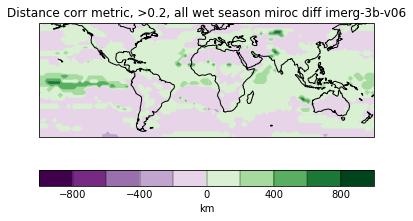

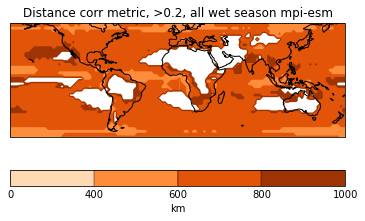

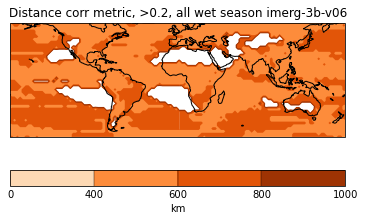

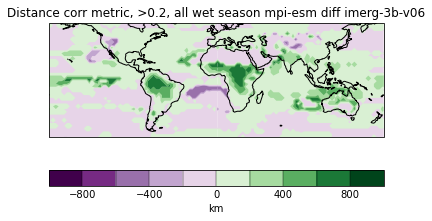

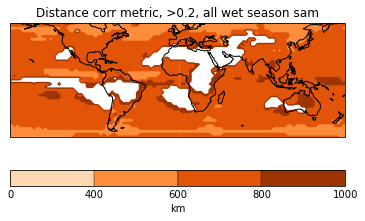

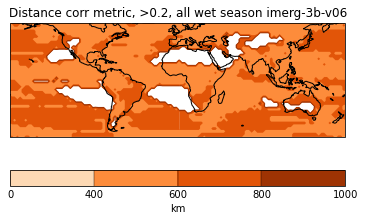

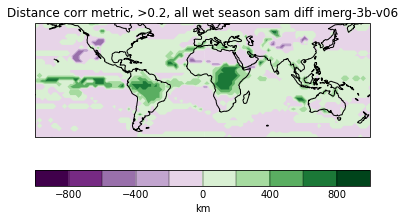

In [32]:
for model in models:
    model_dict = get_asop_dict(model)
    model_spatial_summary,model_ponon,model_ponoff,model_poffon,model_poffoff = load_all_summary_metrics(model_dict)
    model_autocorr_filename = str(model_dict['dir'])+'/'+model_dict['desc']+'_asop_spatial_corr_wetseason1d24.nc'
    model_autocorr = load_summary_metric(model_autocorr_filename,'distance_correlations',None,'km')
    model_threshold = find_distcorr_threshold(model_autocorr,threshold=threshold,long_name='Distance corr metric, >'+str(threshold)+', all wet season '+model_dict['name'],units='km')
    plot_summary_metric(model_threshold,gpm_threshold,model_dict,gpm_dict,autocorr_raw_levels,autocorr_diff_levels,'Oranges','brewer_PRGn_11')
#    plot_summary_metric(model_ponon,gpm_ponon,model_dict,gpm_dict,ponon_raw_levs,ponon_diff_levs,'Oranges','brewer_PRGn_11')
#    plot_summary_metric(model_ponoff,gpm_ponoff,model_dict,gpm_dict,ponoff_raw_levs,ponoff_diff_levs,'Oranges','brewer_PRGn_11')
#    plot_summary_metric(model_poffon,gpm_poffon,model_dict,gpm_dict,poffon_raw_levs,poffon_diff_levs,'Oranges','brewer_PRGn_11')
#    plot_summary_metric(model_poffoff,gpm_poffoff,model_dict,gpm_dict,poffoff_raw_levs,poffoff_diff_levs,'Oranges','brewer_PRGn_11')
#    plot_summary_metric(model_spatial_summary,gpm_spatial_summary,model_dict,gpm_dict,summary_raw_levs,summary_diff_levs,'Oranges','brewer_PRGn_11')